In [ ]:
#Run this to set up the environment and the "UnNormalize" tool.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# 1. Setup Paths (Point to your src folder)
# This assumes your notebook is in /notebooks and src is in /src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data.cifar_loader import load_cifar_batch
from src.data.cifar_dataset import CIFAR10Dataset
from src.models.resnet import ResNet18CIFAR

# 2. Setup Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on: {device}")

# 3. Define Normalization Constants (MUST MATCH TRAINING)
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2023, 0.1994, 0.2010)

# 4. Define The Helper Class to Undo Normalization
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args: tensor (Tensor): Normalized image of size (C, H, W)
        Returns: Tensor: Original image (0 to 1)
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# Initialize the tools
unorm = UnNormalize(CIFAR_MEAN, CIFAR_STD)
norm = T.Normalize(CIFAR_MEAN, CIFAR_STD)

Running on: mps


In [ ]:
#The Noise Functions

In [3]:
def add_gaussian_noise(image_tensor, severity):
    """
    Adds static noise.
    Severity: Standard Deviation (e.g., 0.05, 0.1)
    """
    if severity <= 0:
        return image_tensor
    
    noise = torch.randn_like(image_tensor) * severity
    noisy_image = image_tensor + noise
    return torch.clamp(noisy_image, 0, 1)

def add_blur_noise(image_tensor, severity):
    """
    Adds Gaussian Blur.
    Severity: Sigma value (e.g., 0.5, 1.0, 2.0)
    """
    if severity <= 0:
        return image_tensor
    
    # Kernel size must be odd. We stick to 5 to isolate sigma effects.
    k_size = 5 
    blurrer = T.GaussianBlur(kernel_size=k_size, sigma=severity)
    return blurrer(image_tensor)

In [ ]:
#The Experiment Loop (The Fix)

In [7]:
def run_stress_test(model_path, noise_type="gaussian"):
    # --- A. Load Data (Test Set Only) ---
    # We use the standard transform (Normalize only) for the test loader
    test_transform = T.Compose([
        T.ToTensor(),
        norm 
    ])
    
    # Load test batch (data_batch_5 or test_batch if you have it)
    # Adjust path if needed
    data_path = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py/test_batch'
    if not os.path.exists(data_path):
        print("Test batch not found! Using data_batch_5 as proxy...")
        data_path = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py/data_batch_5'
        
    x_test, y_test = load_cifar_batch(data_path)
    test_dataset = CIFAR10Dataset(x_test, np.array(y_test), transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # --- B. Load Model ---
    model = ResNet18CIFAR(num_classes=10).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # --- C. Define Ranges ---
    if noise_type == "gaussian":
        # Testing "Micro-fractures" (0.0 to 0.1)
        steps = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2]
        noise_fn = add_gaussian_noise
    elif noise_type == "blur":
        # Testing "Structure Loss" (0.0 to 2.0)
        steps = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
        noise_fn = add_blur_noise
    
    accuracies = []
    
    print(f"Starting {noise_type.upper()} Stress Test...")
    
    # --- D. The Loop ---
    with torch.no_grad():
        for severity in steps:
            correct = 0
            total = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # 1. UN-NORMALIZE (Restore to 0-1)
                clean_images = images.clone()
                for i in range(clean_images.size(0)):
                    clean_images[i] = unorm(clean_images[i])
                
                # 2. INJECT NOISE
                noisy_images = noise_fn(clean_images, severity)
                
                # 3. RE-NORMALIZE (Prepare for Model)
                final_input = noisy_images.clone()
                for i in range(final_input.size(0)):
                    final_input[i] = norm(final_input[i])
                
                # 4. PREDICT
                outputs = model(final_input)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            acc = 100 * correct / total
            accuracies.append(acc)
            print(f"Severity {severity:.2f} -> Accuracy: {acc:.2f}%")
            
    return steps, accuracies

Starting GAUSSIAN Stress Test...
Severity 0.00 -> Accuracy: 88.70%
Severity 0.02 -> Accuracy: 87.61%
Severity 0.04 -> Accuracy: 80.14%
Severity 0.06 -> Accuracy: 67.02%
Severity 0.08 -> Accuracy: 50.67%
Severity 0.10 -> Accuracy: 36.37%
Severity 0.15 -> Accuracy: 17.87%
Severity 0.20 -> Accuracy: 14.07%
Starting BLUR Stress Test...
Severity 0.00 -> Accuracy: 88.70%
Severity 0.50 -> Accuracy: 86.42%
Severity 1.00 -> Accuracy: 46.16%
Severity 1.50 -> Accuracy: 32.62%
Severity 2.00 -> Accuracy: 30.00%
Severity 2.50 -> Accuracy: 29.63%


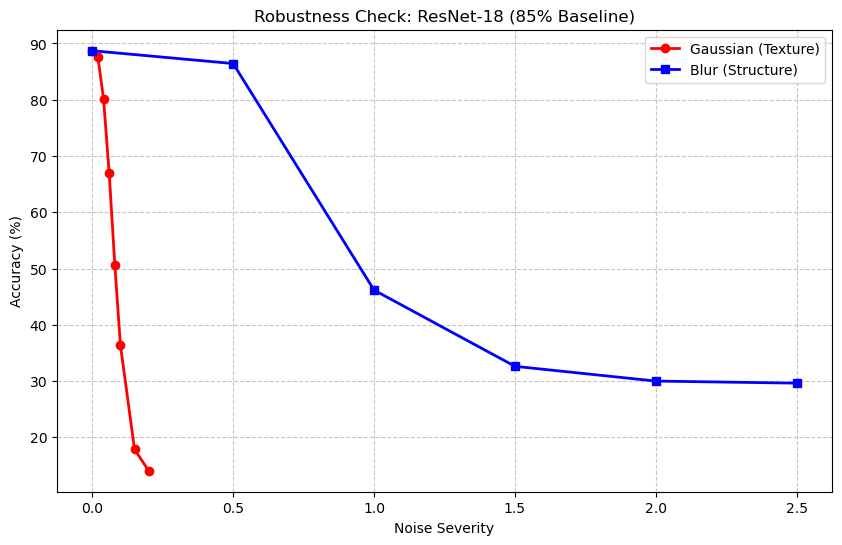

In [9]:
# Path to your NEW 85% model
model_path = '../src/experiments/saved_models/baseline_model.pth'

# 1. Run Gaussian
g_steps, g_acc = run_stress_test(model_path, noise_type="gaussian")

# 2. Run Blur
b_steps, b_acc = run_stress_test(model_path, noise_type="blur")

# 3. Plot Comparison
plt.figure(figsize=(10, 6))
plt.plot(g_steps, g_acc, marker='o', label='Gaussian (Texture)', color='red', linewidth=2)
# We plot Blur on the same X-axis scale for visual comparison, 
# or use two subplots if the scales are too different.
# For now, let's plot them as is.
plt.plot(b_steps, b_acc, marker='s', label='Blur (Structure)', color='blue', linewidth=2)

plt.title(f"Robustness Check: ResNet-18 (85% Baseline)")
plt.xlabel("Noise Severity")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("final_robustness_comparison.png")
plt.show()